In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from typing import List
plt.rcParams['figure.figsize'] = 5, 5

## Задания

0. Нельзя пользоваться фреймворками глубокого обучения - Pytorch, TensorFlow, Keras и т.д.
1. Рассчитать average_digit (матрицу весов) для каждой цифры от 0 до 9, по аналогии с (avg_eight).
2. Создать десять классификаторов с весами "avg_digit". На вход классификатора подаётся цифра из тестового набора, а на выходе мы получаем 0 или 1, в зависимости от того принадлежит ли цифра нужному классу ('0' - '9'). Добавить смещение (bias).
3. Рассчитать точность каждого классификатора.
4. Объеденить получившиеся классификаторы в одну модель, которая принимает картинку, а выдаёт вектор размера 10. (напр. input=[3], output = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]).
5. Рассчитать 𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 и 𝑟𝑒𝑐𝑎𝑙𝑙 получившейся модели на тестовом наборе.
6. Визуализировать набор необработанных данных с помощью алгоритма t-SNE. Взять 30 изображений каждого класса, каждое изображение перевести в вектор размера (784), визуализировать полученные вектора с помощью t-SNE.
7. Визуализировать результаты работы вашей модели (логиты) с помощью алгоритма t-SNE. Прогнать изображения через вашу модель, получившиеся вектора размера (10) визуализировать с помощью t-SNE.

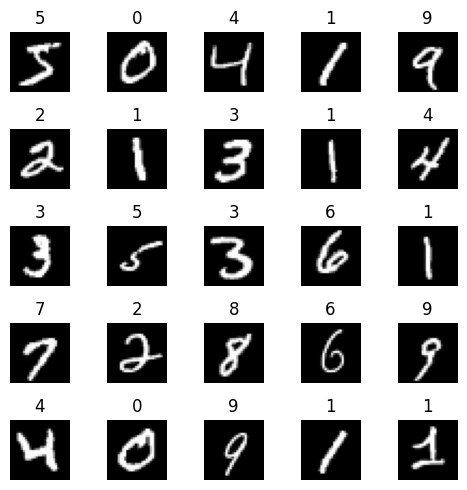

In [5]:

# Initializing the transform for the dataset
transform = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.5), (0.5))
                                            ])

# Downloading the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="./MNIST/train", train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True)

test_dataset = torchvision.datasets.MNIST(
    root="./MNIST/test", train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True)


# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(train_dataset), (25))

for idx in range(random_samples.shape[0]):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(train_dataset[idx][0][0].numpy(), cmap='gray')
    plt.title(train_dataset[idx][1])
    plt.axis('off')


plt.tight_layout()
plt.show()

In [6]:
def encode_label(numb):
  vec = np.zeros((10,1))
  vec[numb] = 1.0
  return vec

In [7]:
def shape_data(data):
  feauteres = [np.reshape(x[0][0].numpy(), (784,1)) for x in data]
  labels = [encode_label(y[1]) for y in data]
  return zip(feauteres, labels)

In [8]:
train = shape_data(train_dataset)
test = shape_data(test_dataset)
train = list(train)
test = list(test)

In [9]:
def avg_digit (data, numb):
  filtered_data = [x[0] for x in data if np.argmax(x[1]) == numb]
  filtered_array = np.asarray(filtered_data)
  return np.average(filtered_array, axis = 0)

### Task1

In [10]:
avg = []
for i in range (10):
  avg.append(avg_digit(train, i))

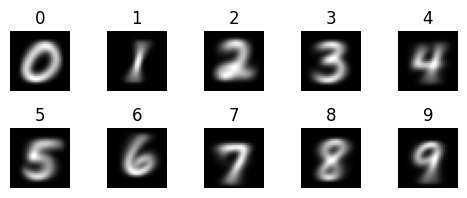

In [11]:
for i in range(10):
    plt.subplot(5, 5, i + 1)
    img = (np.reshape(avg[i], (28,28)))
    plt.imshow(img, cmap='gray')
    plt.title(i)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Task2

In [12]:
def binary_step(x):
    return 1.0 if x>=0 else 0

In [13]:
def is_num(x, num, b):
    W = np.transpose(avg[num])
    return binary_step((np.dot(W,x) + b)/ np.linalg.norm(W))

## Task3

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
offsets = [-44.5, -25.5, -34.5, -37.5, -32.5, -31, -35, -31.5, -37, -34]
acc_score_numb = []

In [16]:
for i in range (len(avg)):
  predicted = []
  correct_answer = []

  for j in range (len(train)):

    if (is_num(train[j][0], i, offsets[i]) == 1):
        predicted.append(1)
    else:
        predicted.append(0)

    correct_answer.append((np.argmax(train[j][1]))==i)

  acc_score = accuracy_score(predicted, correct_answer)
  acc_score_numb.append(acc_score)


In [17]:
len(acc_score_numb)
formatted_acc_scores = [f"{(score * 100):.0f}" for score in acc_score_numb]
print(formatted_acc_scores)

['72', '65', '51', '61', '55', '46', '57', '59', '46', '53']


### Task4

In [18]:
def predict_model(x, num, b):
    W = np.transpose(avg[num])
    return (np.dot(W,x) + b)/ np.linalg.norm(W)

In [19]:
def model (img : np.ndarray) -> list :
  list = []
  for i in range (len(avg)):
    list.append(predict_model(img, i, offsets[i])[0][0])
  idx = np.argmax(list)
  vec = np.zeros((10,1))
  vec[idx] = 1.0
  return vec


### Task5

In [20]:
def test_recall_precision_accuracy():
  TP = 0
  FP = 0
  FN = 0

  predicted = []
  correct_answer = []

  for i in range(len(test)):
      predicted.append(np.argmax(model(test[i][0])))
      correct_answer.append(np.argmax(test[i][1]))

  accuracy_sc = []
  for i in range(len(test)):
    accuracy_sc.append( predicted[i] == correct_answer[i])

  accuracy = sum(accuracy_sc)/len(test)

  precision = np.zeros(10)
  recall = np.zeros(10)

  for i in range(10):
        TP = sum([x == i and y == i for x, y in zip(correct_answer,predicted)])
        FP = sum([x != i and y == i for x, y in zip(correct_answer,predicted)])
        FN = sum([x == i and y != i for x, y in zip(correct_answer,predicted)])

        print(f"Class {i}: TP={TP}, FP={FP}, FN={FN}")


        if TP + FP > 0:
            precision[i] = TP / (TP + FP)
        else:
            precision[i] = 0

        if TP + FN > 0:
            recall[i] = TP / (TP + FN)
        else:
            recall[i] = 0

  precision = np.average(precision)
  recall = np.average(recall)

  return accuracy, precision, recall




In [21]:
accuracy, precision, recall  =  test_recall_precision_accuracy()
print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("Accuracy model:", accuracy)

Class 0: TP=839, FP=50, FN=141
Class 1: TP=1091, FP=294, FN=44
Class 2: TP=833, FP=218, FN=199
Class 3: TP=728, FP=100, FN=282
Class 4: TP=794, FP=149, FN=188
Class 5: TP=657, FP=231, FN=235
Class 6: TP=854, FP=186, FN=104
Class 7: TP=876, FP=107, FN=152
Class 8: TP=780, FP=306, FN=194
Class 9: TP=750, FP=157, FN=259
Precision for each class: 0.8242584021023992
Recall for each class: 0.817813174991579
Accuracy model: 0.8202


### Task6

In [22]:
import random

In [23]:
def division_by_number(data, numb, len_for_digit):
    count = 0
    class_numb = np.zeros((len_for_digit, 784))
    for i in range(len(data)):
        if count == len_for_digit:
            break
        if np.argmax(data[i][1]) == numb:
            class_numb[count] = data[i][0].flatten()
            count += 1
    return class_numb

numb_for_tsne = []

train = random.sample(train, len(train))

for i in range(10):
    numb_for_tsne.append(division_by_number(train, i, 30))


In [24]:
from sklearn.manifold import TSNE

In [25]:
combined_array = np.vstack(numb_for_tsne)
combined_array.shape

(300, 784)

In [26]:
tsne = TSNE(n_components=2, random_state=42)
numb_tsne = tsne.fit_transform(combined_array)

In [27]:
labels = np.array([x for x in range(10) for _ in range(30)])

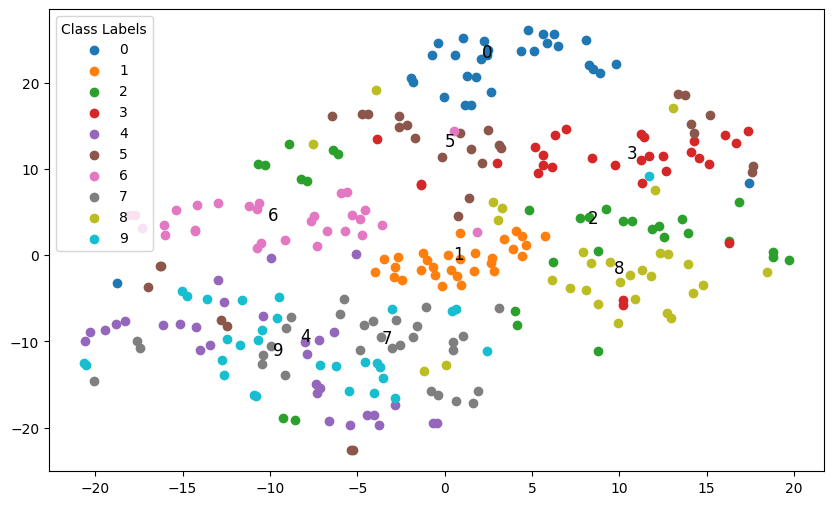

In [28]:
import matplotlib.pyplot as plt

colors = plt.cm.tab10(np.linspace(0, 1, 10))

plt.figure(figsize=(10, 6))

for i in range(10):
    class_points = numb_tsne[labels == i]
    plt.scatter(class_points[:, 0], class_points[:, 1], c=[colors[i]], label=str(i))
    centroid = np.median(class_points, axis=0)
    plt.text(centroid[0], centroid[1], str(i), fontsize=12, ha='center', color='black')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Class Labels", loc='upper left')
plt.show()

### Task7

In [35]:
test = random.sample(test, len(test))


numb_for_model = []
for i in range(10):
    numb_for_model.append(division_by_number(test, i, 10))

combined_array_model = np.vstack(numb_for_model)

In [36]:
predict = np.zeros((100, 10))
for i in range(10*10):
  temp = combined_array_model[i].reshape(784, 1)
  predict[i] = model(temp).reshape(10)

noise = np.random.uniform(0, 0.01, predict.shape)
predict = predict + noise

print(predict.shape)
print(predict[10].shape)

(100, 10)
(10,)


In [41]:
tsne_model = TSNE(n_components=2, random_state=42)
numb_tsne_model = tsne_model.fit_transform(predict)

In [42]:
labels_model = np.array([x for x in range(10) for _ in range(10)])


In [43]:
from scipy import stats

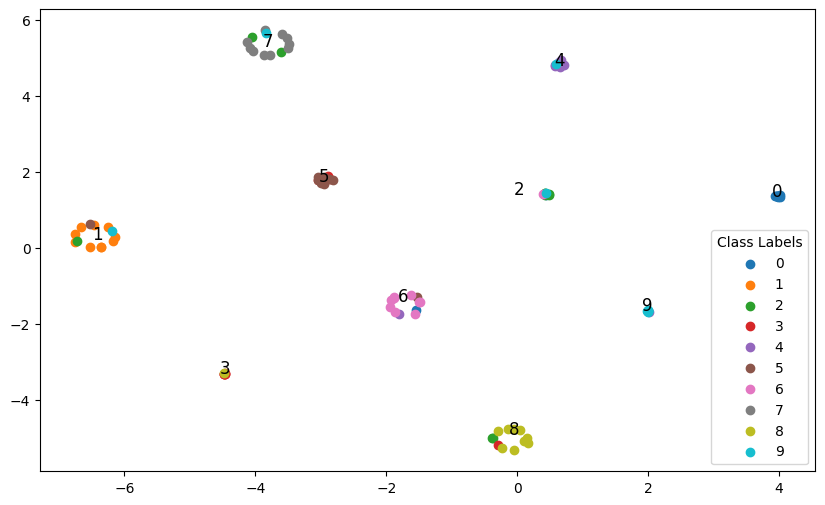

In [45]:
import matplotlib.pyplot as plt

colors = plt.cm.tab10(np.linspace(0, 1, 10))

plt.figure(figsize=(10, 6))

for i in range(10):
    class_points_model = numb_tsne_model[labels_model == i]
    plt.scatter(class_points_model[:, 0], class_points_model[:, 1], c=[colors[i]], label=str(i))
    centroid = np.median(class_points_model, axis=0)
    plt.text(centroid[0], centroid[1], str(i), fontsize=12, ha='center', color='black')

# Добавление легенды

by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Class Labels")
plt.show()